In [ ]:
# necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

In [ ]:
# necessary parameters
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
batch_size = 512
epochs = 20
learning_rate = 1e-4

In [ ]:
# training and test dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]

Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



# **UnderComplete Autoencoder**

In [ ]:
# autoencoder
class UnderCompleteAutoencoder(nn.Module):
    def __init__(self,input_dim):
        super(UnderCompleteAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), int(input_dim*0.25)),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(int(input_dim*0.25), int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), input_dim),
            nn.Sigmoid()  # Sigmoid activation to squash output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = UnderCompleteAutoencoder(input_dim=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate,betas= (0.9,0.99))

# mean-squared error loss
criterion = nn.MSELoss()

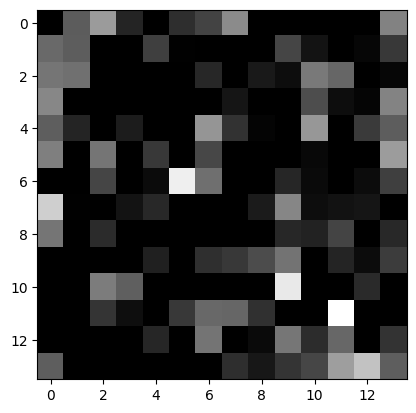

latent vector shape torch.Size([512, 196])
reconstructed image shape torch.Size([512, 784])


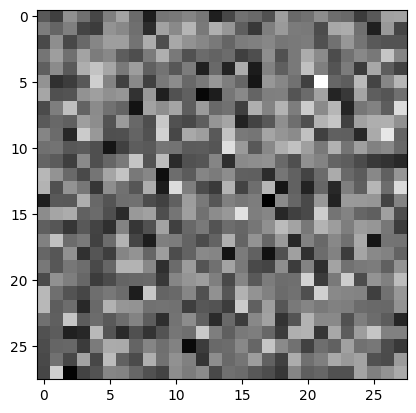

In [ ]:
random_input = torch.rand(512,1,28,28).to(device)
random_input = random_input.view(-1, 784)
latent_vector = model.encoder(random_input)
plt.imshow(latent_vector[0].cpu().detach().numpy().reshape(14, 14))
plt.gray()
plt.show()
print("latent vector shape",latent_vector.shape)
reconstructed_image = model.decoder(latent_vector)
print("reconstructed image shape",reconstructed_image.shape)
# reconstructed_image = reconstructed_image.view(-1,1,28,28)
plt.imshow(reconstructed_image[0].cpu().detach().numpy().reshape(28, 28))
plt.gray()
plt.show()

In [ ]:
# training step
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device

        batch_features = batch_features.view(-1, 784).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()


    # compute the epoch training loss
    loss = loss / len(train_loader)

    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))


epoch : 1/20, recon loss = 0.12253704
epoch : 2/20, recon loss = 0.06614040
epoch : 3/20, recon loss = 0.05555251
epoch : 4/20, recon loss = 0.04537543
epoch : 5/20, recon loss = 0.03957159
epoch : 6/20, recon loss = 0.03522335
epoch : 7/20, recon loss = 0.03120500
epoch : 8/20, recon loss = 0.02776840
epoch : 9/20, recon loss = 0.02517453
epoch : 10/20, recon loss = 0.02292905
epoch : 11/20, recon loss = 0.02123691
epoch : 12/20, recon loss = 0.01992923
epoch : 13/20, recon loss = 0.01873850
epoch : 14/20, recon loss = 0.01766820
epoch : 15/20, recon loss = 0.01675731
epoch : 16/20, recon loss = 0.01593204
epoch : 17/20, recon loss = 0.01517336
epoch : 18/20, recon loss = 0.01450056
epoch : 19/20, recon loss = 0.01391270
epoch : 20/20, recon loss = 0.01336942


In [ ]:
# evaluate the results
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0].to(device)
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

## Visualizing Results

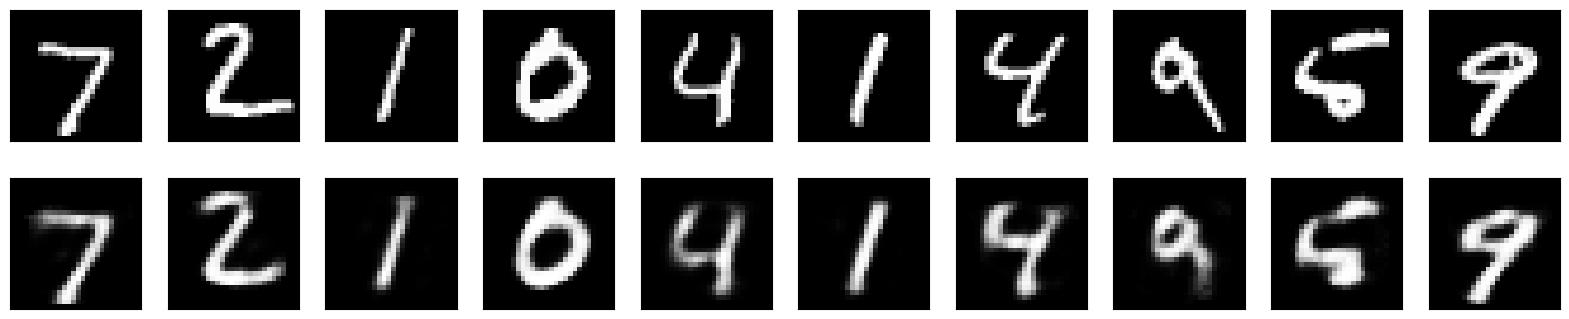

In [ ]:

with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# **OverComplete Autoencoder**

In [ ]:
# Overcomplete Autoencoder
# Model definition
class OverCompleteAutoencoder(nn.Module):
    def __init__(self,input_dim):
        super(OverCompleteAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*4),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(input_dim*4, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim),
            nn.Sigmoid()  # Sigmoid activation to squash output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `OvercompleteAutoencoder` autoencoder class
# load it to the specified device, either gpu or cpu
model = OverCompleteAutoencoder(input_dim=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

## Training the Autoencoder Model

In [ ]:
# training step
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(train_loader)

    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))


epoch : 1/20, recon loss = 0.08090264
epoch : 2/20, recon loss = 0.03894392
epoch : 3/20, recon loss = 0.02624957
epoch : 4/20, recon loss = 0.01957254
epoch : 5/20, recon loss = 0.01573047
epoch : 6/20, recon loss = 0.01349378
epoch : 7/20, recon loss = 0.01193927
epoch : 8/20, recon loss = 0.01072874
epoch : 9/20, recon loss = 0.00988152
epoch : 10/20, recon loss = 0.00914067
epoch : 11/20, recon loss = 0.00846526
epoch : 12/20, recon loss = 0.00787794
epoch : 13/20, recon loss = 0.00741413
epoch : 14/20, recon loss = 0.00707946
epoch : 15/20, recon loss = 0.00680052
epoch : 16/20, recon loss = 0.00653288
epoch : 17/20, recon loss = 0.00622295
epoch : 18/20, recon loss = 0.00596030
epoch : 19/20, recon loss = 0.00573538
epoch : 20/20, recon loss = 0.00551874


In [ ]:
# evaluate the results
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0].to(device)
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

## Visualizing Results

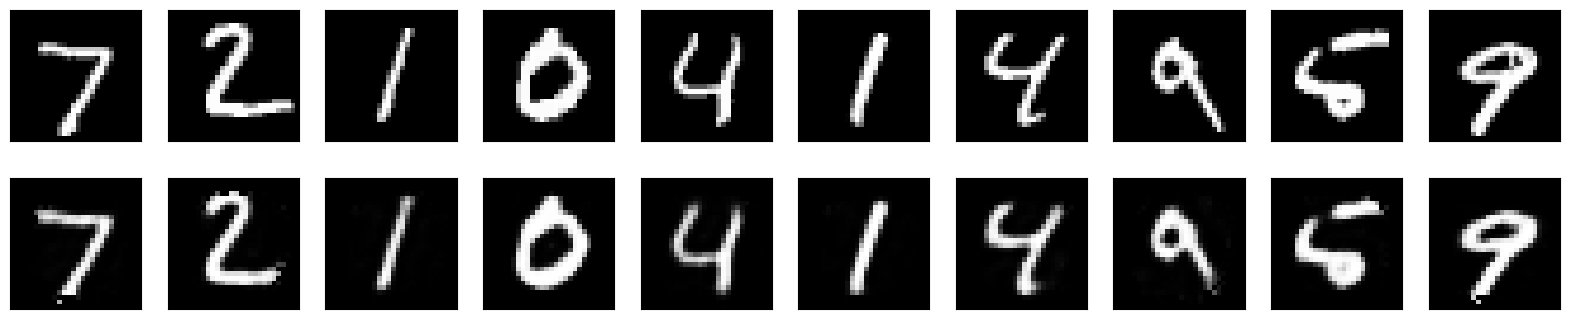

In [ ]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# **Sparse Autoencoder**

In [ ]:
# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self,input_dim):
        super(SparseAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), int(input_dim*0.25)),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(int(input_dim*0.25), int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), input_dim),
            nn.Sigmoid()  # Sigmoid activation to squash output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `SparseAutoencoder` autoencoder class
# load it to the specified device, either gpu or cpu
model = SparseAutoencoder(input_dim=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

## Defining loss function for training the Sparse Autoencoder Model

In [ ]:
reg_param = 1e-3
# get the layers as a list
model_children = list(model.children())
# define the sparse loss function
def sparse_loss(autoencoder, images):
    loss = 0
    values = images
    for i in range(2):
        fc = list(model.encoder.children())[2 * i]
        act = list(model.encoder.children())[2 * i + 1]
        values = act(fc(values))
        loss += torch.mean(torch.abs(values))
    for i in range(2):
        fc = list(model.decoder.children())[2 * i]
        act = list(model.decoder.children())[2 * i + 1]
        values = act(fc(values))
        loss += torch.mean(torch.abs(values))
    return loss

## Training the Autoencoder Model

In [ ]:
# training step
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training reconstruction loss
        l1_loss = sparse_loss(model, batch_features)

        train_loss = criterion(outputs, batch_features) + l1_loss * reg_param

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(train_loader)

    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))


epoch : 1/20, recon loss = 0.12637296
epoch : 2/20, recon loss = 0.07073418
epoch : 3/20, recon loss = 0.06025196
epoch : 4/20, recon loss = 0.04831869
epoch : 5/20, recon loss = 0.04094807
epoch : 6/20, recon loss = 0.03553421
epoch : 7/20, recon loss = 0.03111165
epoch : 8/20, recon loss = 0.02783804
epoch : 9/20, recon loss = 0.02524526
epoch : 10/20, recon loss = 0.02325807
epoch : 11/20, recon loss = 0.02171779
epoch : 12/20, recon loss = 0.02037015
epoch : 13/20, recon loss = 0.01918205
epoch : 14/20, recon loss = 0.01814930
epoch : 15/20, recon loss = 0.01722953
epoch : 16/20, recon loss = 0.01645775
epoch : 17/20, recon loss = 0.01582681
epoch : 18/20, recon loss = 0.01528324
epoch : 19/20, recon loss = 0.01475652
epoch : 20/20, recon loss = 0.01426718


In [ ]:
# evaluate the results
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0].to(device)
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

## Visualizing Results

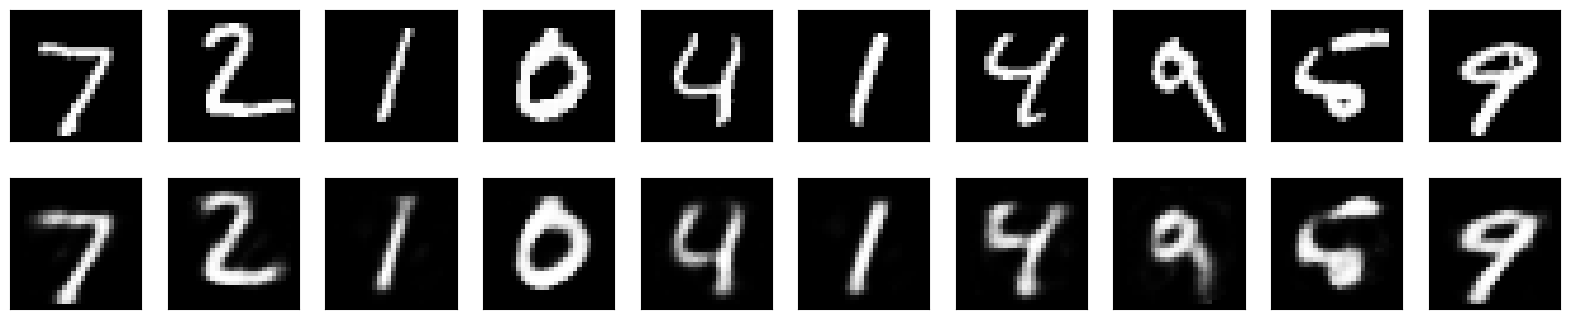

In [ ]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# **Denoising Autoencoder**

In [ ]:
# Denoising Autoencoder

def noise_input(images):
    return images * (1 - NOISE_RATIO) + torch.rand(images.size()) * NOISE_RATIO
NOISE_RATIO = 0.4
noise_images = noise_input(test_examples.cpu())

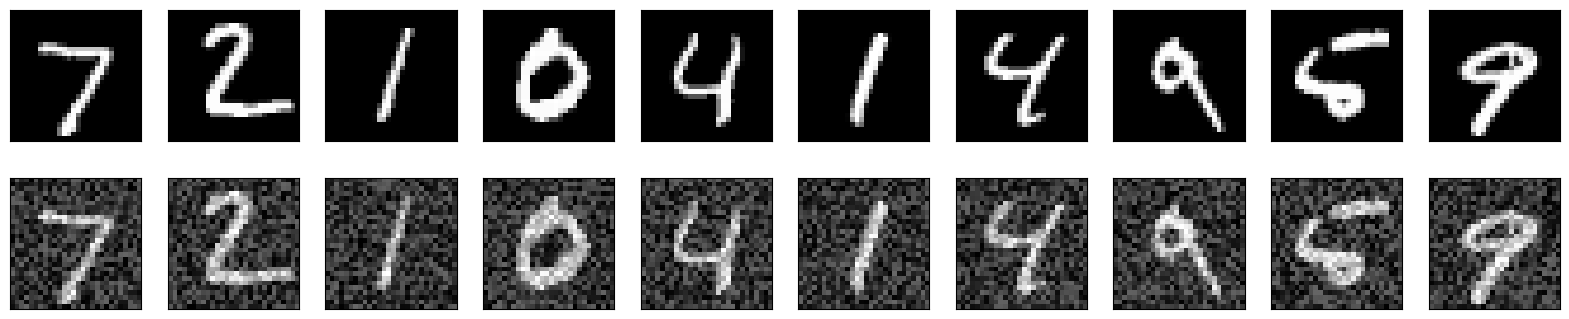

In [ ]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(noise_images[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()